# Assignment 5

Explore embeddings and CNN

Using tweeter dataset ( https://www.kaggle.com/utathya/sentiment-analysis-of-imdb-reviews/data) and already existing splitting on train/test sets, develop a model for sentiment analysis.  
Your quality metric is crossentropy (`sklearn.metrics.log_loss`, `torch.nn.CrossEntropy`)  

Your model should be based on CNN and written in pytorch `torch.nn.Conv1d`.

Explore 3 ways, which of them has better perfomance on test set?:
1. Using pretrained word embeddings with frozen weights. `torch.nn.Embedding.from_pretrained(embed_matrix, frozen=True)`.
You can download any pretrained embeddings you like.
2. Train embeddings yourself, initializing from pretrained weights. `torch.nn.Embedding.from_pretrained(embed_matrix, frozen=False)`
3. Train embeddings yourself with random initialization `torch.nn.init.uniform_(nn.Embeddings.weights)`

Experiment with model arhitecture (as bonus):
1. activation functions RELU, ELU, etc `torch.nn.functional.relu, torch.nn.functional.elu`  
1. Stack layers
1. max or average pooling (`torch.nn.functional.max_pool1d, torch.nn.functional.avg_pool1d`)
1. Dropout


Other requirements:
1. Your training routine should use any learning scheduler (torch.nn.optim.lr_scheduler).  
Plot current learning rate against number of epochs, e.g. `tt.optim.Adam.param_groups[0]['lr']`.  

1. Your training routine should use early stopping on validation dataset
Use hold out validation scheme in your experiments.

1. You should use torchtext for parsing 

**Note**:
This assignment has no baseline. Instead, **validation curves** for explored architectures are expected.  
Validation curve is plot of model test score against model hyperparameter value.  
example (https://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html) . 
Though, using `sklearn.model_selection.validation_curve` is not necessary.  






In [1]:
import pandas as pd
import numpy as np
from sklearn.externals import joblib
import nltk
import gensim
import spacy

from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import SnowballStemmer
from string import punctuation

from sklearn import metrics

import torch as tt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchtext.data import Field, LabelField, BucketIterator, TabularDataset, Iterator


SEED = 42
np.random.seed(SEED)


stop_words = set(stopwords.words('english'))
tweet_tokenizer = TweetTokenizer()
snowball_stemmer = SnowballStemmer('english')

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv('imdb_master.csv', encoding='latin-1', index_col = 0)

train = data[data.type.isin(['train'])]
test = data[data.type.isin(['test'])]

# imdb_train = df_master[["review", "label"]][df_master.type.isin(['train'])].reset_index(drop=True)
# imdb_test = df_master[["review", "label"]][df_master.type.isin(['test'])].reset_index(drop=True)

In [4]:
train.head()

,type,review,label,file
25000,train,Story of a man who has unnatural feelings for ...,neg,0_3.txt
25001,train,Airport '77 starts as a brand new luxury 747 p...,neg,10000_4.txt
25002,train,This film lacked something I couldn't put my f...,neg,10001_4.txt
25003,train,"Sorry everyone,,, I know this is supposed to b...",neg,10002_1.txt
25004,train,When I was little my parents took me along to ...,neg,10003_1.txt


In [5]:
test.head()

,type,review,label,file
0,test,Once again Mr. Costner has dragged out a movie...,neg,0_2.txt
1,test,This is an example of why the majority of acti...,neg,10000_4.txt
2,test,"First of all I hate those moronic rappers, who...",neg,10001_1.txt
3,test,Not even the Beatles could write songs everyon...,neg,10002_3.txt
4,test,Brass pictures (movies is not a fitting word f...,neg,10003_3.txt


In [6]:
def tokenizer(text):
    tokens = tweet_tokenizer.tokenize(snowball_stemmer.stem(text))
    result = [word for word in tokens if word != ' '  \
              and word.strip() not in punctuation + '«»—…“”№–']
    
    return result

In [7]:
set(train['label'].values)

{'neg', 'pos', 'unsup'}

In [8]:
set(test['label'].values)

{'neg', 'pos'}

Удалим метку `unsup` (т.к. она отсутствует в тестовой выборке):

In [9]:
train = train[train['label'] != 'unsup']

In [10]:
train.to_csv('train.csv', encoding='utf-8')
test.to_csv('test.csv', encoding='utf-8')

### TorchText

In [11]:
classes={
    'neg' : 0,
    'pos' : 1
}

TEXT = Field(include_lengths=True, batch_first=True, 
             tokenize=tokenizer,
             eos_token='<eos>',
             lower=True,
             stop_words=stop_words)

LABEL = LabelField(dtype=tt.int64, use_vocab=True, preprocessing=lambda x: classes[x])


train = TabularDataset('train.csv', format='csv', 
                         fields=[(None, None), (None, None), ('review', TEXT), ('label', LABEL), (None, None)], 
                         skip_header=True)

test = TabularDataset('test.csv', format='csv', 
                         fields=[(None, None), (None, None), ('review', TEXT), ('label', LABEL), (None, None)], 
                         skip_header=True)

In [12]:
TEXT.build_vocab(train, vectors='glove.6B.100d')

In [13]:
embed_matrix = TEXT.vocab.vectors

In [14]:
LABEL.build_vocab(train)

In [15]:
train, valid = train.split(0.7, stratified=True)

___

In [16]:
class MyModel(nn.Module):
    
    def __init__(self, vocab_size, embed_size, embed_matrix, hidden_size, kernels, freeze_value):
        super(MyModel, self).__init__()
        
        if embed_matrix is None:
            print('3rd task: train embeddings yourself with random initialization.')
            self.embedding = nn.Embedding(vocab_size, embed_size)
        
        else:
            self.embedding = nn.Embedding.from_pretrained(embed_matrix, freeze=freeze_value)
            
            if freeze_value:
                print('1st task: use pretrained word embeddings with frozen weights.')
            else:
                print('2nd task: train embeddings yourself, initializing from pretrained weights.')
        
        self.convs = nn.ModuleList([nn.Conv1d(embed_size, hidden_size, k, padding=5) for k in kernels])
        self.fc = nn.Linear(hidden_size * len(kernels), 3)
        
    def forward(self, x):
        
        x = self.embedding(x)
        x = x.transpose(1,2)
        
        concatenated = []
        for conv in self.convs:
            z = conv(x)
            z = F.avg_pool1d(z, kernel_size=z.size(2))
            z = z.squeeze(2)
            concatenated.append(z)
            
        x = tt.cat(concatenated, 1)
        x = self.fc(x)
        
        return x

In [17]:
def train_nn(model, epochs, train_iterator, valid_iterator, optimizer, scheduler, criterion):
    min_loss = np.inf
    no_improvement = 0
    
    lr = []
    all_train_loss = []
    all_val_loss = []
    
    for epoch in range(epochs):
        val_loss_history = []
        train_loss_history = []
        
        for batch in train_iterator:
            optimizer.zero_grad()
            
            pred = model.forward(batch.review[0])
            loss = criterion(pred, batch.label)
            tr_loss = loss.item()
            train_loss_history.append(tr_loss)
        
            loss.backward()
            optimizer.step()
                
        train_mean = np.mean(train_loss_history)
        all_train_loss.append(train_mean)
        
        with tt.no_grad():
            for val_batch in valid_iterator:
                val_pred = model.forward(val_batch.review[0])
                val_loss_crit = criterion(val_pred, val_batch.label)
                valid_loss = val_loss_crit.item()
                val_loss_history.append(valid_loss)
        
            val_loss = np.mean(val_loss_history)
            all_val_loss.append(val_loss)
        
        if val_loss < min_loss:
            min_loss = val_loss
            no_improvement = 0

        elif no_improvement < scheduler.patience:
            no_improvement += 1

        else:
            print('Early stopping (%dth epoch)' % (epoch + 1))
            break
        
        lr.append(optimizer.param_groups[0]['lr'])
        scheduler.step(val_loss)
    
        print('Epoch %d, Train Loss: %.4f, Validation Loss: %.4f' % (epoch + 1, train_mean, val_loss))
        
    return lr, all_train_loss, all_val_loss

In [18]:
def eval_test(model, test_iterator, criterion):
    epoch_loss = 0

    with tt.no_grad():
        for batch in test_iterator:
            pred = model.forward(batch.review[0])
            loss = criterion(pred, batch.label)
            epoch_loss += loss.data.item()

    return epoch_loss / len(test_iterator)

#### Plots

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

In [20]:
def plot_lr(lr):
    plt.plot(range(len(lr)), lr)
    plt.xlabel('Number of epoch')
    plt.ylabel('Learning rate')
    plt.title('Learning rate against number of epochs')

In [21]:
def plot_losses(train_loss, val_loss):
    plt.plot(range(len(train_loss)), train_loss, label='train loss')
    plt.plot(range(len(val_loss)), val_loss, label='validation loss')
    plt.xlabel('Number of epoch')
    plt.ylabel('Loss value')
    plt.legend()
    plt.title('Train and Validation losses')

In [22]:
def plot_val_curve(test_1, test_2, test_3):
    ax = plt.figure(figsize=(14,8)).add_subplot(111)

    x = 'pretrained word embeddings with frozen weights', 'from pretrained weights', 'random initialization'
    y = test_1, test_2, test_3

    plt.plot(x, y)

    for i, j in zip(x, y):  
        ax.annotate('%s' % j, xy=(i, j), textcoords='offset points')

    plt.xlabel('Model type')
    plt.ylabel('Test loss value')
    plt.title('Validation curve')

### Explore 3 ways, which of them has better perfomance on test set?

In [23]:
batch_size = 256
epochs = 15

criterion = nn.CrossEntropyLoss()

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train, valid, test),
    batch_sizes=(batch_size, batch_size, batch_size),
    shuffle=True,
    sort_key=lambda x: len(x.review)
)

**1. Using pretrained word embeddings with frozen weights.**

In [24]:
tt.cuda.empty_cache()

model_pretrained_frozen = MyModel(len(TEXT.vocab.itos),
                                  embed_size=100,
                                  embed_matrix=embed_matrix,
                                  hidden_size=128,
                                  kernels=[2,3,4,5],
                                  freeze_value=True
                                 )

optimizer_pretrained_frozen = optim.Adam(model_pretrained_frozen.parameters())
scheduler_pretrained_frozen = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_pretrained_frozen, 
    patience=5, 
    verbose=True, 
    cooldown=5
)

1st task: use pretrained word embeddings with frozen weights.


In [25]:
%%time

lr_1, all_train_loss_1, all_val_loss_1 = train_nn(
    model_pretrained_frozen, 
    epochs, 
    train_iterator, 
    valid_iterator, 
    optimizer_pretrained_frozen, 
    scheduler_pretrained_frozen, 
    criterion
)

Epoch 1, Train Loss: 0.6769, Validation Loss: 0.7112
Epoch 2, Train Loss: 0.5481, Validation Loss: 0.7360
Epoch 3, Train Loss: 0.5127, Validation Loss: 0.7831
Epoch 4, Train Loss: 0.4935, Validation Loss: 0.8532
Epoch 5, Train Loss: 0.4885, Validation Loss: 0.8362
Epoch 6, Train Loss: 0.4833, Validation Loss: 0.8553
Early stopping (7th epoch)
CPU times: user 24min 59s, sys: 5min 31s, total: 30min 30s
Wall time: 7min 27s


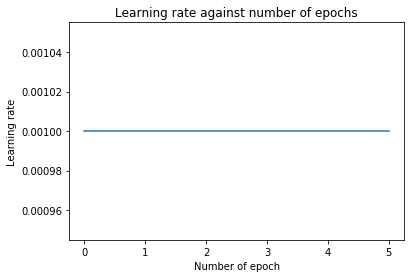

In [26]:
plot_lr(lr_1)

С `learning rate` во всех случаях получилось так (возможно, где-то есть ошибка :( я много раз просматривала код, чтобы ее найти (+ меняла параметры, `patience`, например), но все равно могла не заметить)

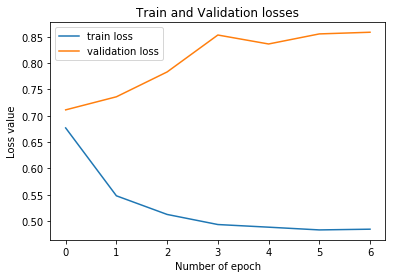

In [27]:
plot_losses(all_train_loss_1, all_val_loss_1)

In [28]:
test_1 = eval_test(model_pretrained_frozen, test_iterator, criterion)

**2. Train embeddings yourself, initializing from pretrained weights.**

In [32]:
tt.cuda.empty_cache()

model_pretrained = MyModel(len(TEXT.vocab.itos),
                           embed_size=100,
                           embed_matrix=embed_matrix,
                           hidden_size=128,
                           kernels=[2,3,4,5],
                           freeze_value=False
                          )

optimizer_pretrained = optim.Adam(model_pretrained.parameters())
scheduler_pretrained = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_pretrained, 
    patience=5, 
    verbose=True, 
    cooldown=5
)

2nd task: train embeddings yourself, initializing from pretrained weights.


In [33]:
%%time

lr_2, all_train_loss_2, all_val_loss_2 = train_nn(
    model_pretrained, 
    epochs, 
    train_iterator, 
    valid_iterator, 
    optimizer_pretrained, 
    scheduler_pretrained, 
    criterion
)

Epoch 1, Train Loss: 0.5474, Validation Loss: 0.5105
Epoch 2, Train Loss: 0.2578, Validation Loss: 0.7035
Epoch 3, Train Loss: 0.1827, Validation Loss: 0.8146
Epoch 4, Train Loss: 0.1376, Validation Loss: 0.9070
Epoch 5, Train Loss: 0.1082, Validation Loss: 1.0138
Epoch 6, Train Loss: 0.0832, Validation Loss: 1.1111
Early stopping (7th epoch)
CPU times: user 39min 27s, sys: 9min 12s, total: 48min 40s
Wall time: 13min 23s


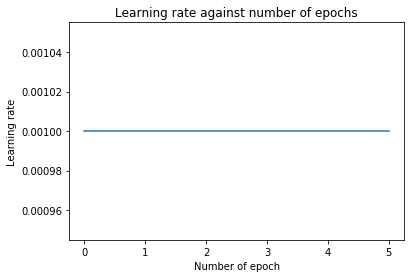

In [35]:
plot_lr(lr_2)

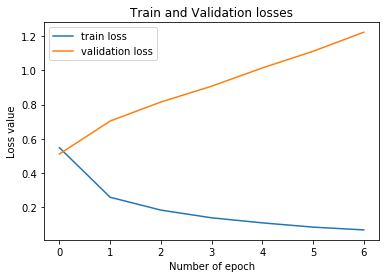

In [36]:
plot_losses(all_train_loss_2, all_val_loss_2)

In [37]:
test_2 = eval_test(model_pretrained, test_iterator, criterion)

**3. Train embeddings yourself with random initialization.**

In [44]:
tt.cuda.empty_cache()

In [45]:
model_self = MyModel(len(TEXT.vocab.itos),
                           embed_size=100,
                           embed_matrix=None,
                           hidden_size=128,
                           kernels=[2,3,4,5],
                           freeze_value=None
                          )

optimizer_self = optim.Adam(model_self.parameters())
scheduler_self = optim.lr_scheduler.ReduceLROnPlateau(optimizer_self, patience=5, verbose=True, cooldown=5)

3rd task: train embeddings yourself with random initialization.


In [46]:
%%time

lr_3, all_train_loss_3, all_val_loss_3 = train_nn(
    model_self, 
    epochs, 
    train_iterator, 
    valid_iterator, 
    optimizer_self, 
    scheduler_self, 
    criterion
)

Epoch 1, Train Loss: 0.7167, Validation Loss: 0.8106
Epoch 2, Train Loss: 0.6861, Validation Loss: 0.7314
Epoch 3, Train Loss: 0.6491, Validation Loss: 0.6636
Epoch 4, Train Loss: 0.5433, Validation Loss: 0.7569
Epoch 5, Train Loss: 0.4528, Validation Loss: 0.8192
Epoch 6, Train Loss: 0.3636, Validation Loss: 0.8830
Epoch 7, Train Loss: 0.3409, Validation Loss: 0.8745
Epoch 8, Train Loss: 0.2722, Validation Loss: 0.9074
Early stopping (9th epoch)
CPU times: user 50min 40s, sys: 11min 45s, total: 1h 2min 26s
Wall time: 16min 58s


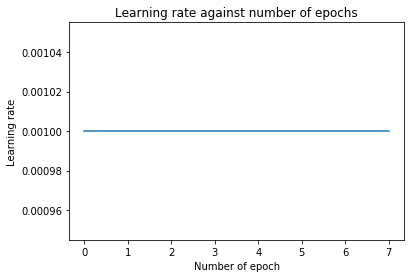

In [47]:
plot_lr(lr_3)

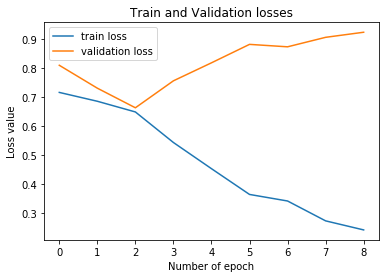

In [48]:
plot_losses(all_train_loss_3, all_val_loss_3)

In [49]:
test_3 = eval_test(model_self, test_iterator, criterion)

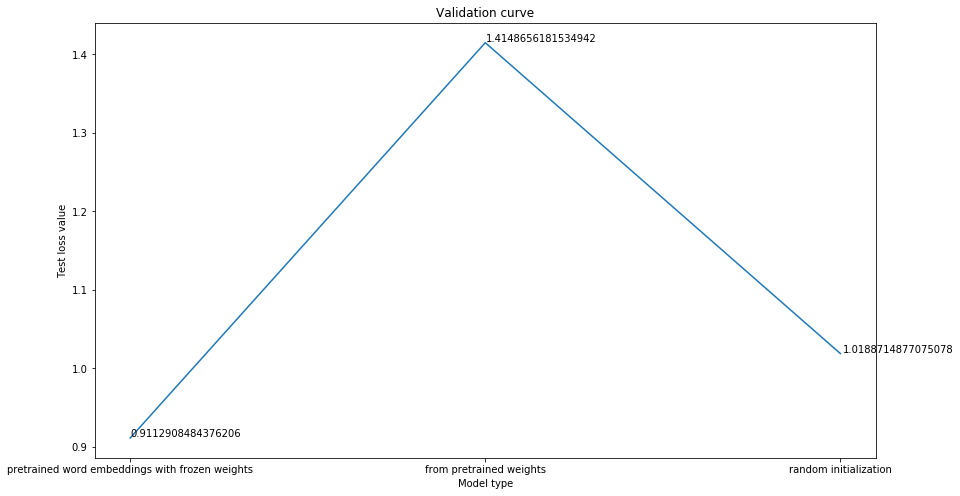

In [50]:
plot_val_curve(test_1, test_2, test_3)